# Training models on campaigns in the same area

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from keras.optimizers import RMSprop # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import seaborn as sns

In [193]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

### Prossessing functions

In [194]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]


'''
    Returns a sequence indicating if a handover has happened when predicting 1 timestep ahead
'''
def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

def check_handover_array(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y[i] == y[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y[i] == 0 and y[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y[i] == 1 and y[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

### LSTM functions

In [ ]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []

    for i in range(len(y_pred)):
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.abs(pred_series - true_series)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    # prepare test data for plots
    if len(test_campaigns) == 1:
        y_pred = model.predict(X_test, verbose=0) 

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(y_test)
        test[features] = scaler.inverse_transform(test[features])

        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test), :] = y_pred

        train_pred = model.predict(X, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        train[features] = scaler.inverse_transform(train[features])
        _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
        y_train_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train), :] = train_pred

    else:
        test_test = test[test['campaign'] == test_campaigns[0]]
        test_seq, test_test_seq = series_split_sequences(test_test, test_test[target_feature], n_steps_in, n_steps_out)
        y_pred = model.predict(test_seq, verbose=0)

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(test_test_seq)
        test_test[features] = scaler.inverse_transform(test_test[features])

        y_true_plot = test_test[target_feature].values
        y_pred_plot = np.empty_like(test_test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test_test), :] = y_pred

        test_train = train[train['campaign'] == campaigns[0]]
        test_train_seq, test_y_seq = series_split_sequences(test_train, test_train[target_feature], n_steps_in, n_steps_out)
        train_pred = model.predict(test_train_seq, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        test_train[features] = scaler.inverse_transform(test_train[features])
        test_y_seq = scaler_pred.inverse_transform(test_y_seq)

        y_train_plot = test_train[target_feature].values
        train_pred_plot = np.empty_like(test_train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(test_train), :] = train_pred

    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred_plot,
               'y_true': y_true_plot,
               'train_pred': train_pred_plot,
               'train_true': y_train_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

### Random Forest functions

In [196]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

In [197]:
# Parameters
tf.random.set_seed(4567)

# LSTM
n_steps_in = 5
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

In [198]:
op1_df = read_dataset('datasets/Op1_merged.csv')
op1_campaigns = op1_df['campaign'].unique().tolist()

op2_df = read_dataset('datasets/Op2_merged.csv')
op2_campaigns = op2_df['campaign'].unique().tolist()


In [199]:
op1_fig = go.Figure()

for campaign in op1_campaigns:
    current_route = op1_df[op1_df['campaign'] == campaign]
    op1_fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=campaign))

op1_fig.update_layout(
    height=420,
    mapbox=dict(
        style='carto-positron',
        zoom=11,
        center=dict(lon=op1_df['Longitude'].mean(), lat=op1_df['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
op1_fig.show()

### Overlapping campaigns

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

In [200]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi', 
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [201]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[0]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[1]])

In [202]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

lstm_results = {}

In [203]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            # print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)

In [204]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR -> RSRP",0.00198,0.00196,0.96,1.15
1,"RSRP, RSRQ -> RSRP",0.00195,0.00206,0.66,0.90
2,"RSRP, SINR, RSRQ -> RSRP",0.00192,0.00233,1.01,1.16
3,"RSRP, SSS_RSRP -> RSRP",0.00197,0.00250,1.04,1.22
4,All -> RSRP,0.00208,0.00214,1.20,1.26
5,"RSRP, SINR -> SINR",0.00174,0.00247,0.75,1.13
6,"SINR, RSRQ -> SINR",0.00153,0.00180,0.46,0.79
7,"RSRP, SINR, RSRQ -> SINR",0.00155,0.00344,0.58,0.99
8,"SINR, SSS_SINR -> SINR",0.00155,0.00142,0.64,0.87
9,All -> SINR,0.00169,0.00265,0.68,1.04


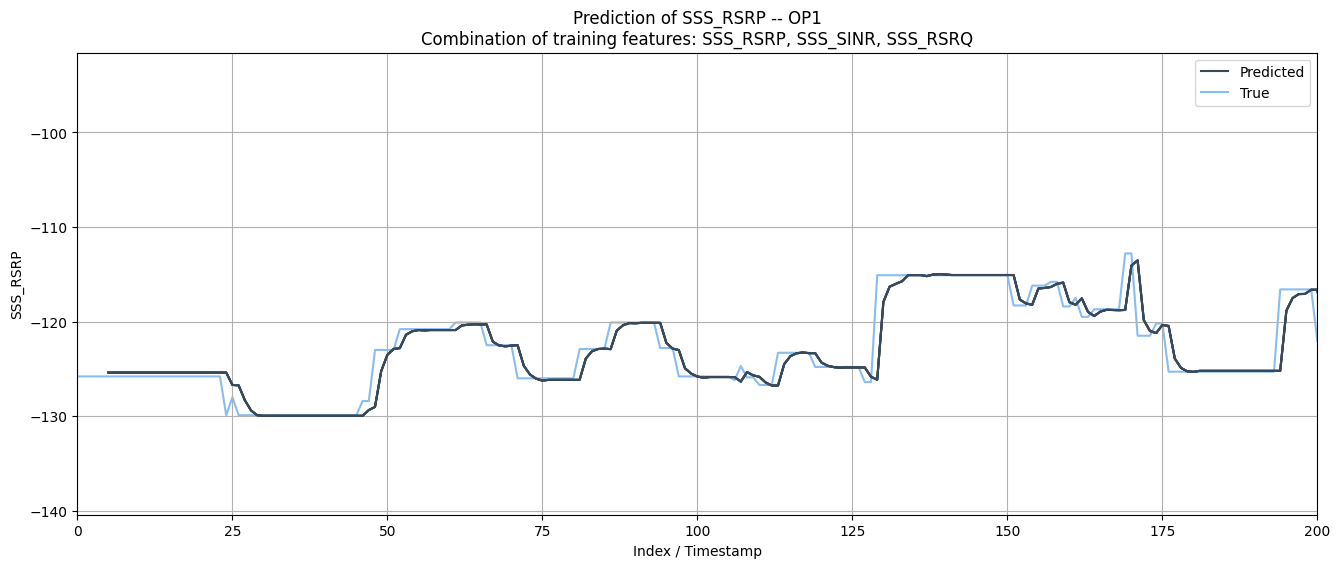

In [205]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = lstm_results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP -- OP1\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

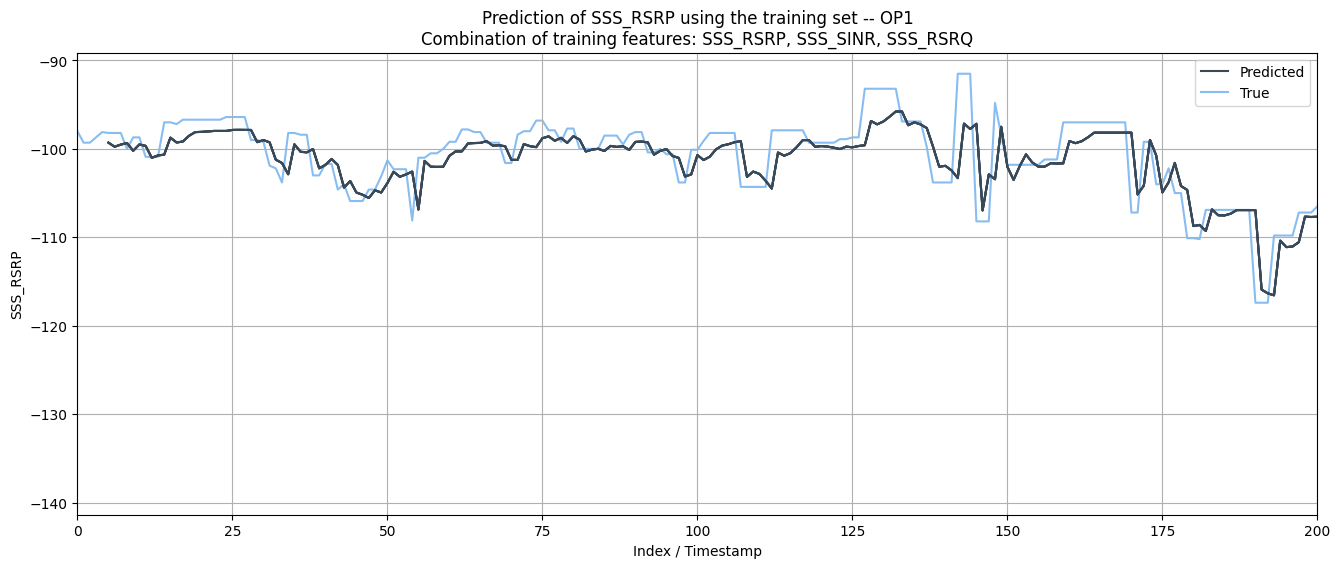

In [206]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set -- OP1\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

## Random Forest

In [215]:
est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

### Overlap 1

In [216]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.546,0.491,0.104,0.999,0.995,1.000
1,"n_est: 5, min_leaf: 2",0.547,0.487,0.055,0.999,0.995,1.000
2,"n_est: 5, min_leaf: 5",0.556,0.543,0.108,0.996,0.980,1.000
3,"n_est: 5, min_leaf: 7",0.551,0.514,0.106,0.994,0.977,0.990
4,"n_est: 5, min_leaf: 9",0.581,0.636,0.168,0.992,0.967,0.990
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.558,0.559,0.106,0.997,0.990,0.992
73,"n_est: 300, min_leaf: 7",0.562,0.585,0.108,0.995,0.977,0.992
74,"n_est: 300, min_leaf: 9",0.559,0.555,0.118,0.995,0.977,0.992
75,"n_est: 300, min_leaf: 12",0.557,0.545,0.113,0.991,0.957,0.992


In [217]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.560
Mean precision: 0.568
Mean recall: 0.112


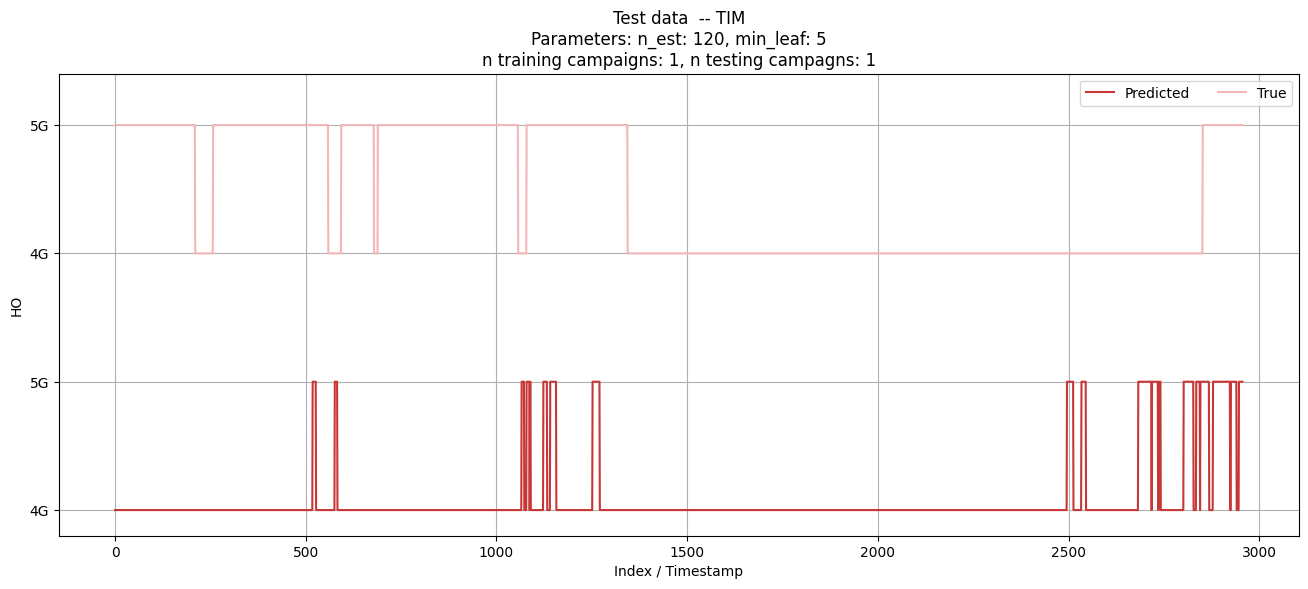

In [218]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data  -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

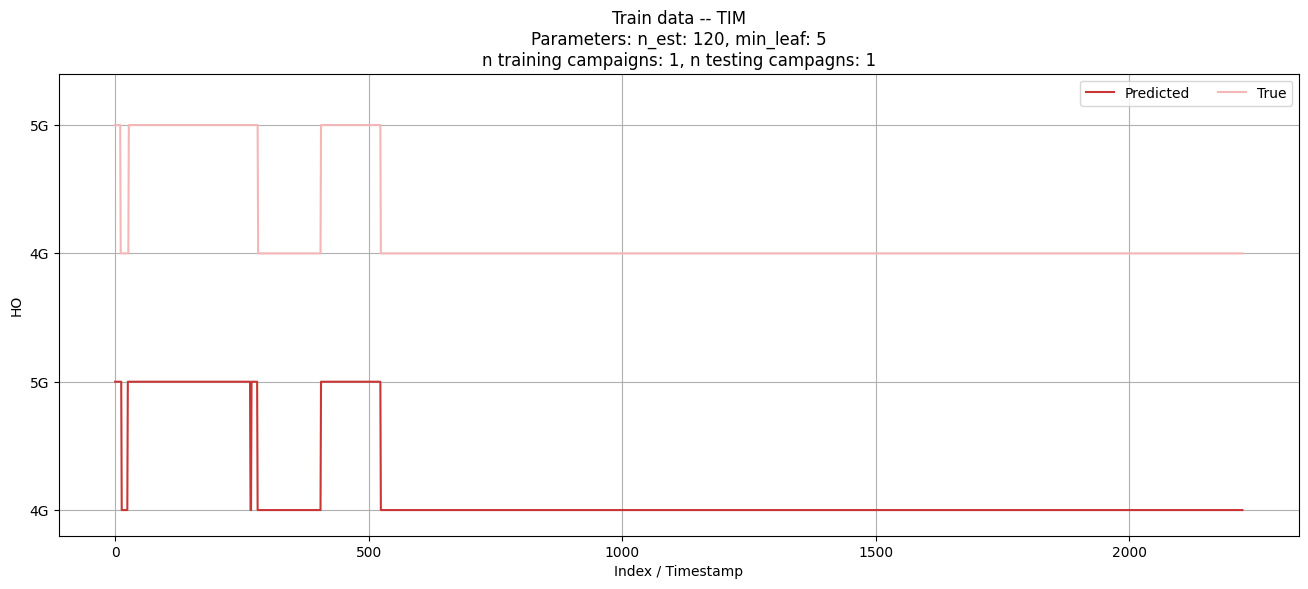

In [219]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [220]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.534,0.417,0.079,0.999,0.995,1.000
1,"n_est: 5, min_leaf: 2",0.542,0.461,0.079,0.998,0.995,0.995
2,"n_est: 5, min_leaf: 5",0.513,0.335,0.079,0.998,0.992,0.997
3,"n_est: 5, min_leaf: 7",0.527,0.383,0.079,0.990,0.946,1.000
4,"n_est: 5, min_leaf: 9",0.528,0.390,0.079,0.992,0.958,0.997
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.527,0.385,0.079,0.998,0.990,1.000
73,"n_est: 300, min_leaf: 7",0.527,0.385,0.079,0.995,0.972,1.000
74,"n_est: 300, min_leaf: 9",0.527,0.385,0.079,0.994,0.967,1.000
75,"n_est: 300, min_leaf: 12",0.527,0.385,0.079,0.992,0.958,1.000


In [221]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.527
Mean precision: 0.387
Mean recall: 0.079


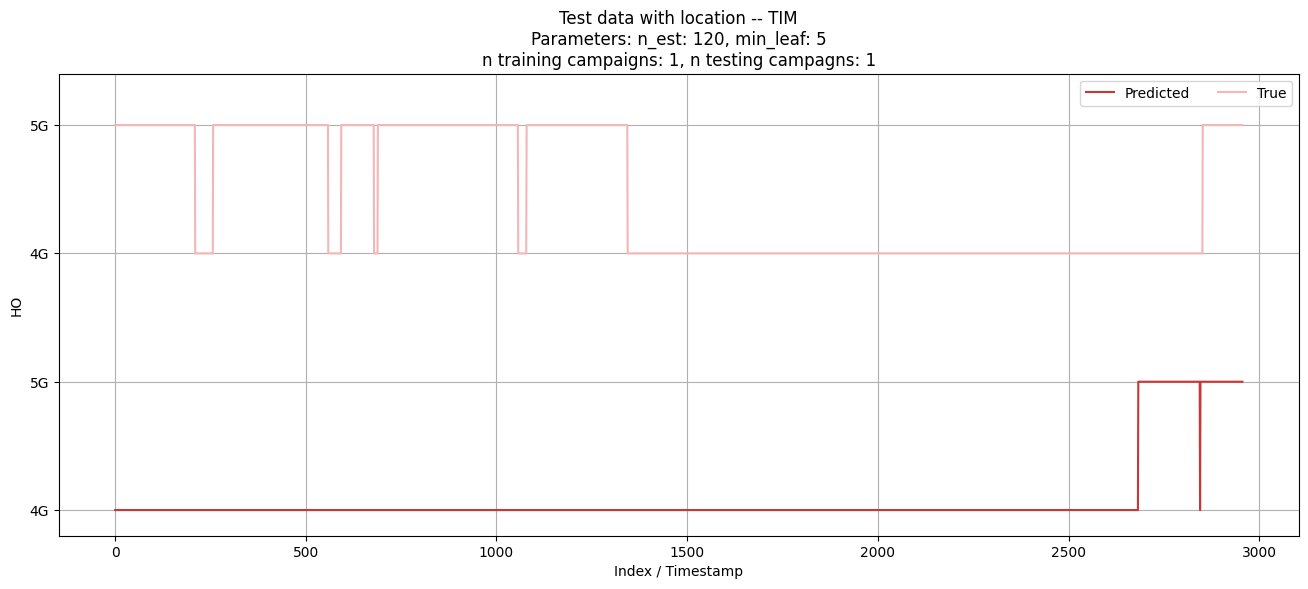

In [222]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

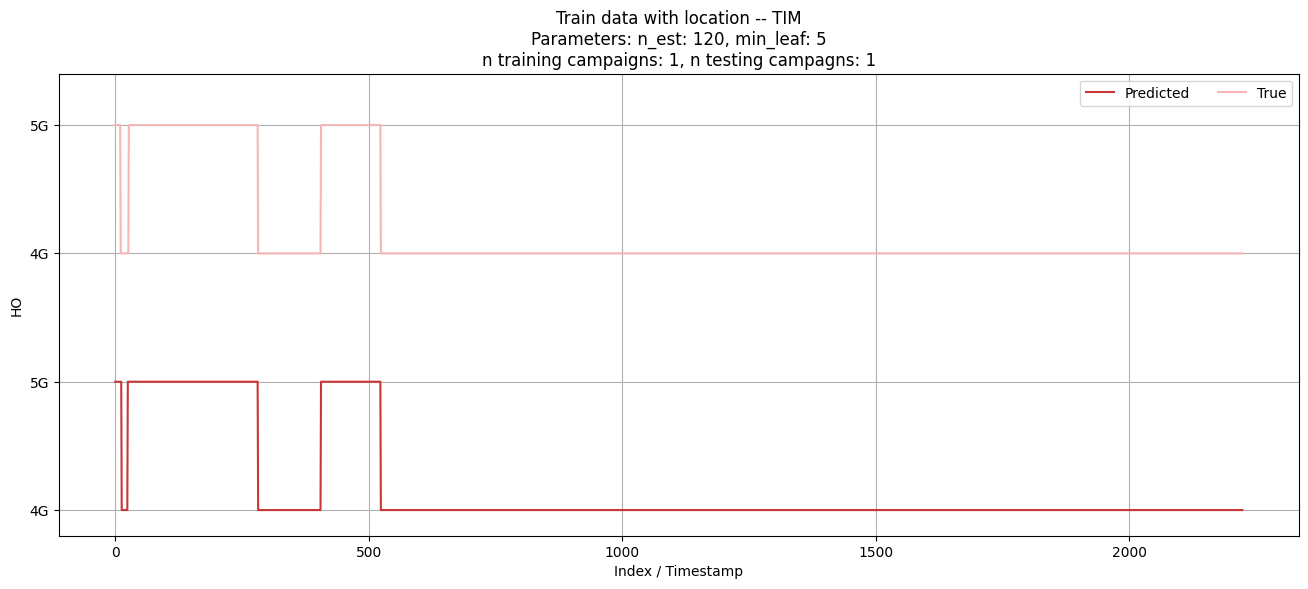

In [223]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data with location -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train on two, test on one

In [224]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[0], overlap_1[2]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[1]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [225]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.622,0.625,0.406,0.998,0.994,0.998
1,"n_est: 5, min_leaf: 2",0.630,0.660,0.374,0.996,0.992,0.994
2,"n_est: 5, min_leaf: 5",0.636,0.660,0.400,0.990,0.979,0.988
3,"n_est: 5, min_leaf: 7",0.632,0.647,0.408,0.987,0.972,0.986
4,"n_est: 5, min_leaf: 9",0.605,0.595,0.392,0.985,0.965,0.988
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.637,0.678,0.373,0.995,0.990,0.994
73,"n_est: 300, min_leaf: 7",0.637,0.685,0.364,0.992,0.983,0.991
74,"n_est: 300, min_leaf: 9",0.636,0.666,0.389,0.987,0.967,0.991
75,"n_est: 300, min_leaf: 12",0.633,0.670,0.370,0.986,0.965,0.991


In [226]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.632
Mean precision: 0.670
Mean recall: 0.368


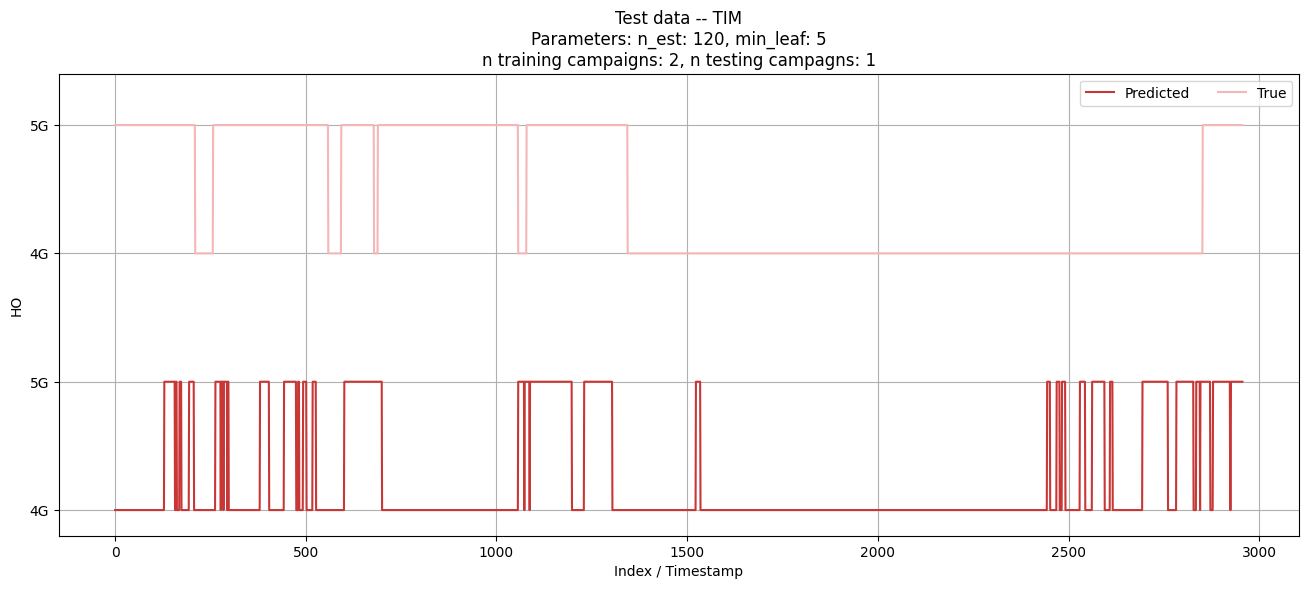

In [227]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

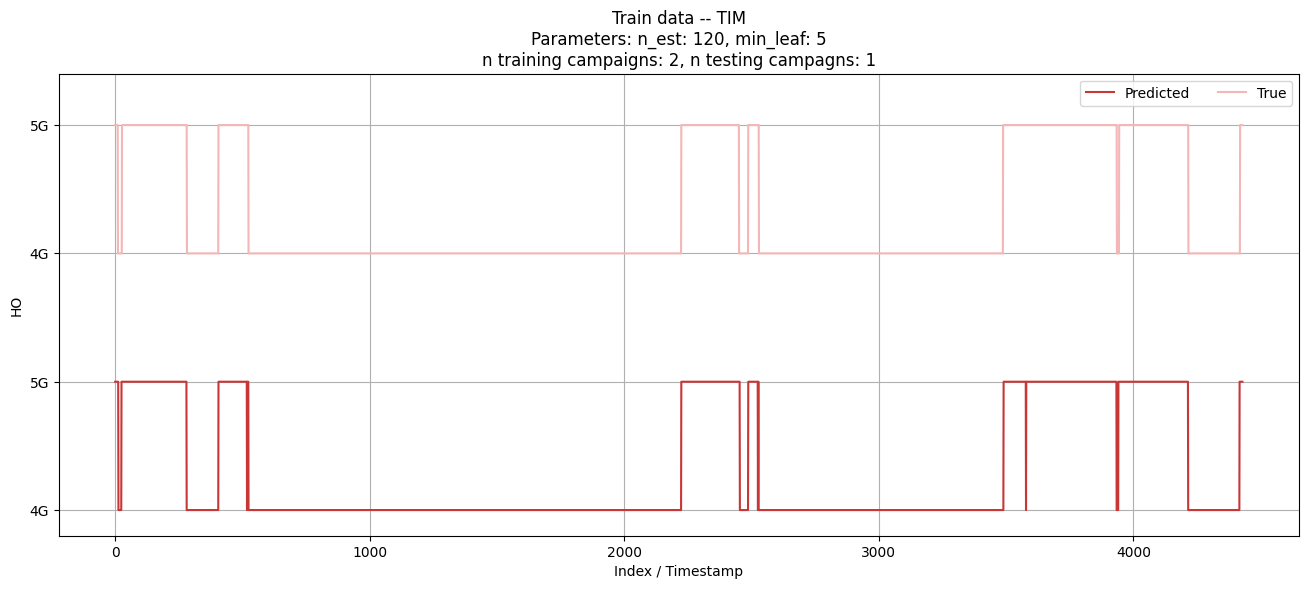

In [228]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [229]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.721,0.759,0.561,0.999,1.000,0.996
1,"n_est: 5, min_leaf: 2",0.679,0.718,0.478,0.998,0.994,0.999
2,"n_est: 5, min_leaf: 5",0.777,0.781,0.706,0.996,0.992,0.995
3,"n_est: 5, min_leaf: 7",0.699,0.727,0.533,0.992,0.980,0.996
4,"n_est: 5, min_leaf: 9",0.708,0.816,0.457,0.993,0.981,0.998
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.700,0.751,0.504,0.996,0.989,0.999
73,"n_est: 300, min_leaf: 7",0.704,0.753,0.513,0.995,0.987,0.997
74,"n_est: 300, min_leaf: 9",0.707,0.759,0.515,0.993,0.980,0.997
75,"n_est: 300, min_leaf: 12",0.700,0.750,0.504,0.991,0.977,0.996


In [230]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.703
Mean precision: 0.753
Mean recall: 0.509


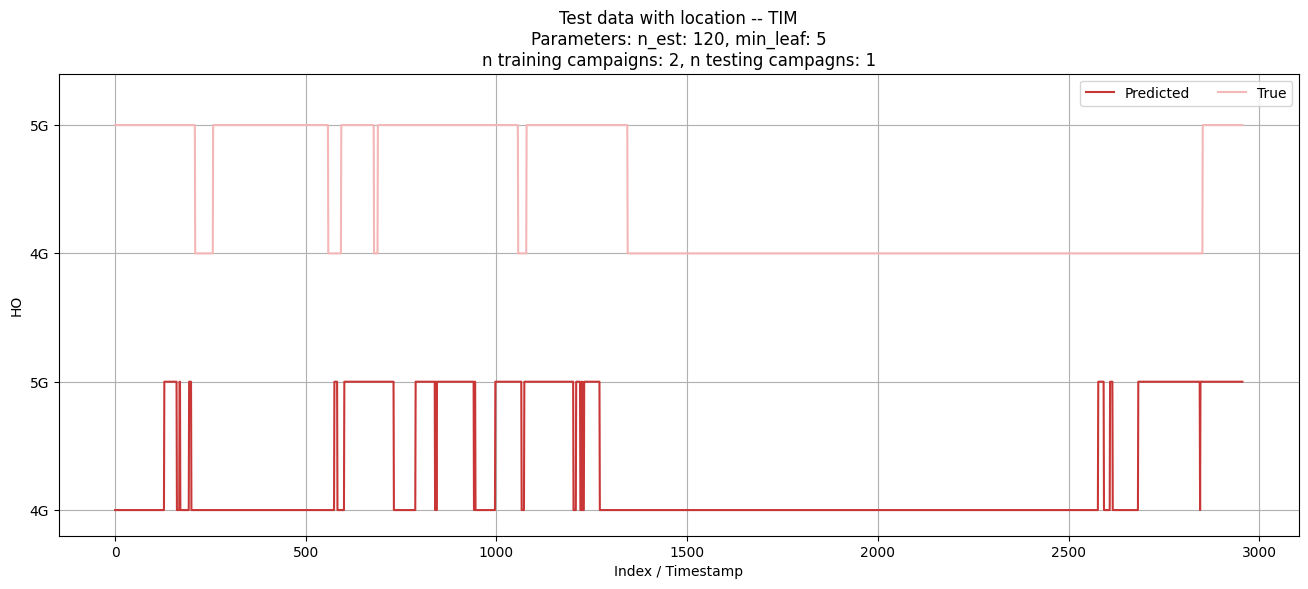

In [231]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train on three, test on two

In [232]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[0], overlap_1[2], overlap_1[3]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[1], overlap_1[4]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [233]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.690,0.568,0.282,0.997,0.994,0.996
1,"n_est: 5, min_leaf: 2",0.673,0.523,0.194,0.997,0.994,0.995
2,"n_est: 5, min_leaf: 5",0.696,0.595,0.270,0.991,0.975,0.991
3,"n_est: 5, min_leaf: 7",0.692,0.601,0.220,0.988,0.965,0.989
4,"n_est: 5, min_leaf: 9",0.699,0.597,0.292,0.984,0.950,0.988
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.701,0.644,0.226,0.995,0.987,0.993
73,"n_est: 300, min_leaf: 7",0.701,0.637,0.235,0.994,0.983,0.991
74,"n_est: 300, min_leaf: 9",0.700,0.635,0.230,0.990,0.971,0.991
75,"n_est: 300, min_leaf: 12",0.700,0.638,0.229,0.987,0.961,0.989


In [234]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.699
Mean precision: 0.627
Mean recall: 0.235


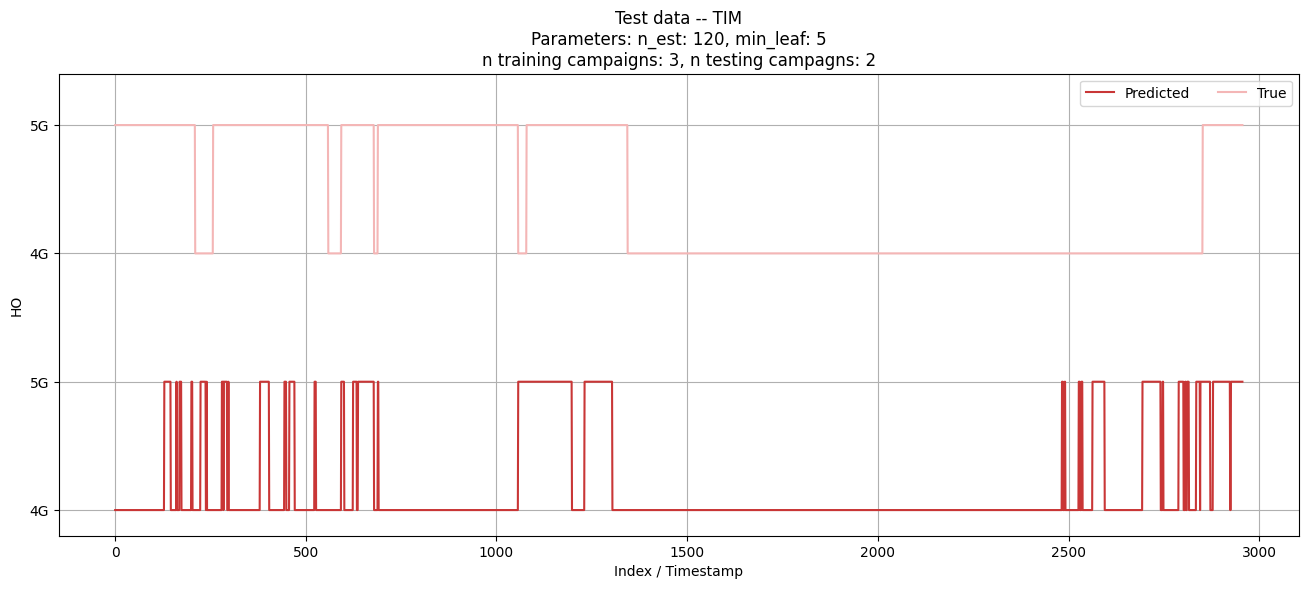

In [235]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

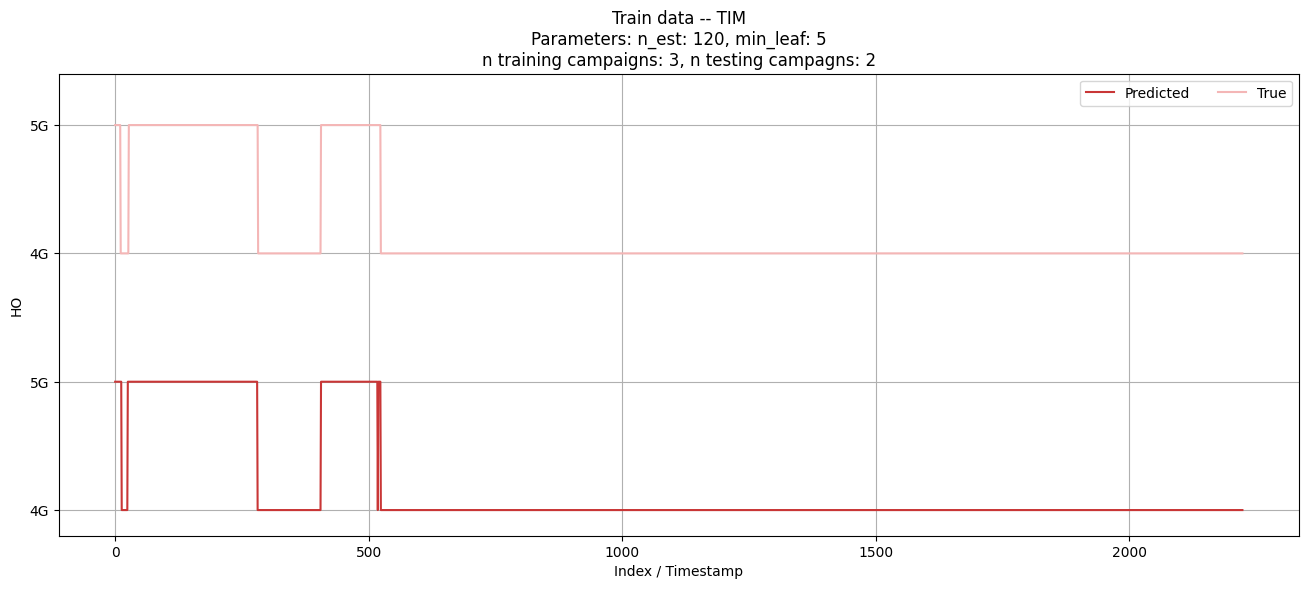

In [236]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [237]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.694,0.678,0.155,0.998,0.996,0.998
1,"n_est: 5, min_leaf: 2",0.706,0.714,0.194,0.998,0.995,0.996
2,"n_est: 5, min_leaf: 5",0.705,0.713,0.191,0.996,0.988,0.996
3,"n_est: 5, min_leaf: 7",0.742,0.868,0.265,0.992,0.978,0.993
4,"n_est: 5, min_leaf: 9",0.705,0.727,0.181,0.994,0.979,0.996
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.716,0.909,0.163,0.997,0.989,0.998
73,"n_est: 300, min_leaf: 7",0.715,0.864,0.172,0.995,0.985,0.996
74,"n_est: 300, min_leaf: 9",0.714,0.865,0.168,0.995,0.984,0.996
75,"n_est: 300, min_leaf: 12",0.717,0.846,0.181,0.994,0.979,0.996


In [238]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.714
Mean precision: 0.848
Mean recall: 0.175


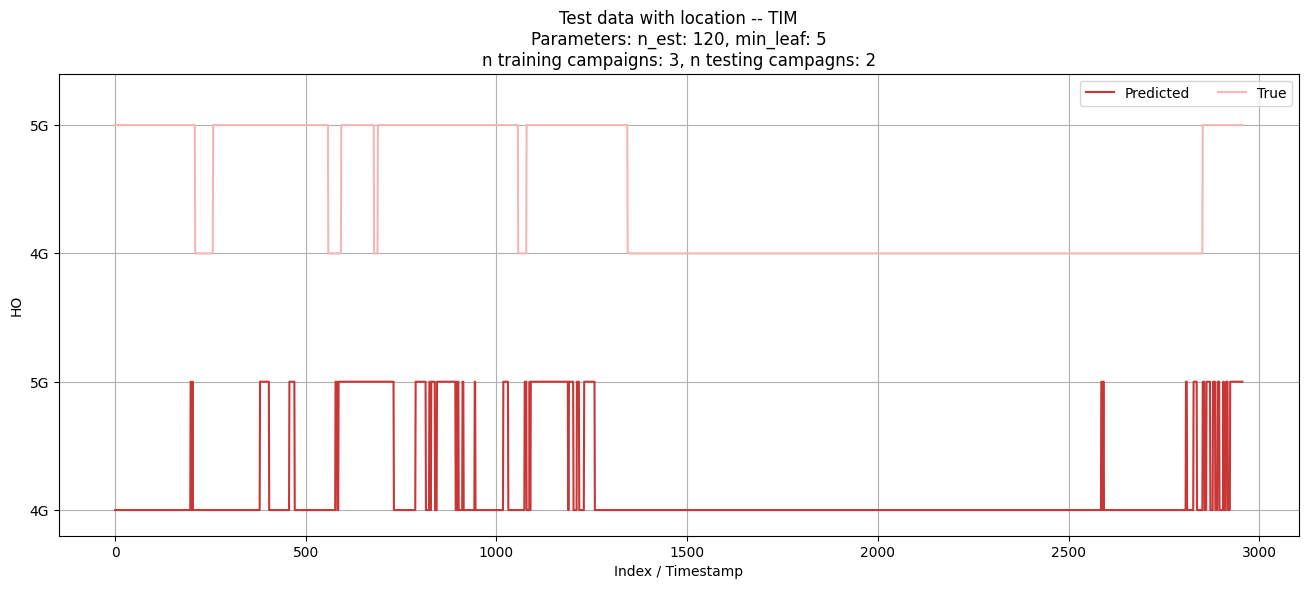

In [239]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Overlap 2

In [240]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_2[0]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_2[1]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [241]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.836,0.0,0.0,0.999,0.999,0.999
1,"n_est: 5, min_leaf: 2",0.858,0.0,0.0,0.999,0.999,0.999
2,"n_est: 5, min_leaf: 5",0.867,0.0,0.0,0.997,0.995,0.995
3,"n_est: 5, min_leaf: 7",0.875,0.0,0.0,0.995,0.991,0.990
4,"n_est: 5, min_leaf: 9",0.863,0.0,0.0,0.994,0.986,0.993
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.840,0.0,0.0,0.999,0.998,0.998
73,"n_est: 300, min_leaf: 7",0.844,0.0,0.0,0.999,0.999,0.998
74,"n_est: 300, min_leaf: 9",0.842,0.0,0.0,0.996,0.991,0.996
75,"n_est: 300, min_leaf: 12",0.845,0.0,0.0,0.994,0.982,0.994


In [242]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.848
Mean precision: 0.000
Mean recall: 0.000


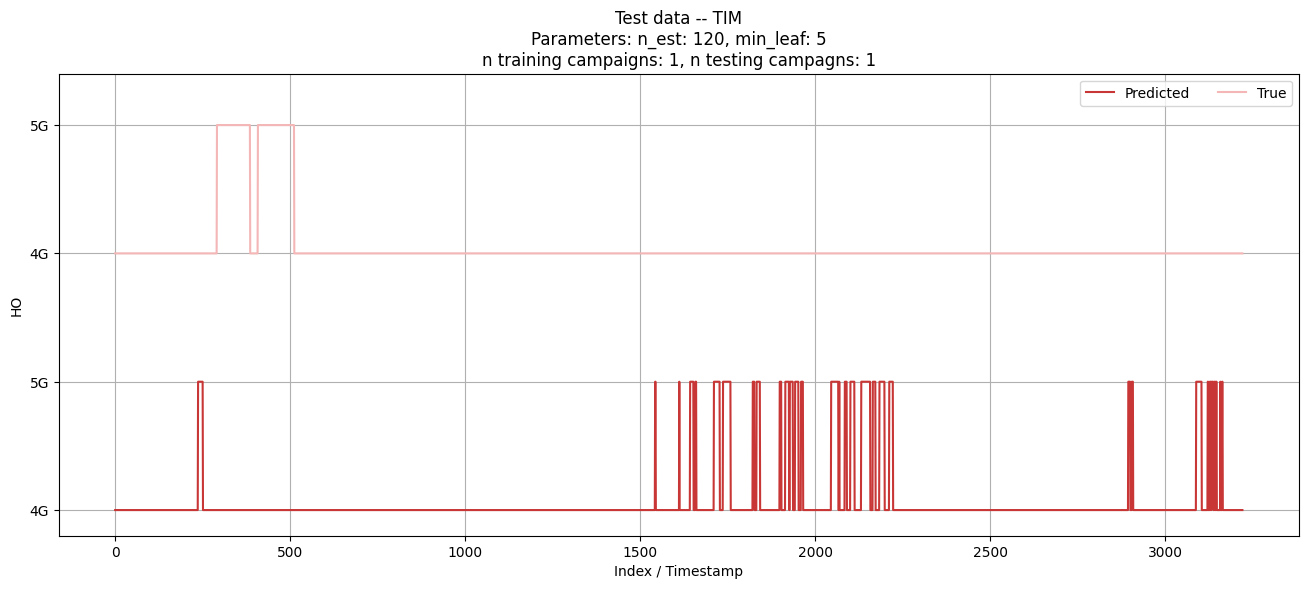

In [243]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

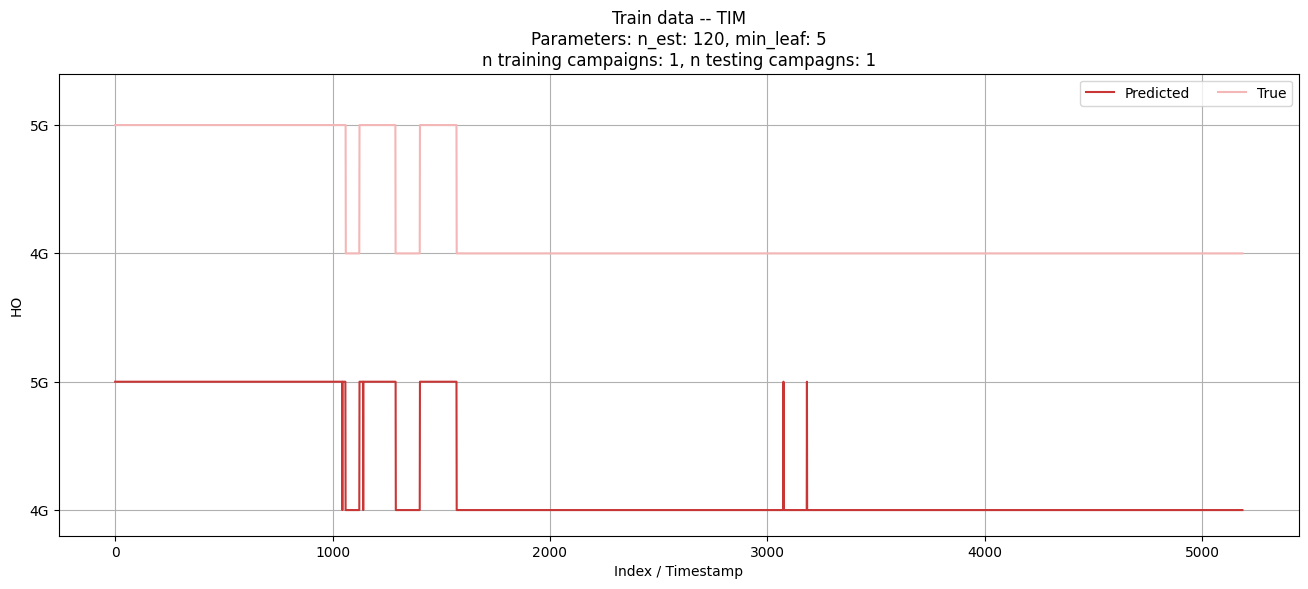

In [244]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [245]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.935,0.0,0.0,1.000,1.000,1.000
1,"n_est: 5, min_leaf: 2",0.928,0.0,0.0,1.000,1.000,1.000
2,"n_est: 5, min_leaf: 5",0.932,0.0,0.0,0.999,0.999,0.996
3,"n_est: 5, min_leaf: 7",0.926,0.0,0.0,0.999,0.996,1.000
4,"n_est: 5, min_leaf: 9",0.928,0.0,0.0,0.999,0.996,0.999
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.932,0.0,0.0,1.000,1.000,1.000
73,"n_est: 300, min_leaf: 7",0.932,0.0,0.0,1.000,1.000,0.999
74,"n_est: 300, min_leaf: 9",0.931,0.0,0.0,1.000,1.000,1.000
75,"n_est: 300, min_leaf: 12",0.930,0.0,0.0,0.999,0.996,1.000


In [246]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.932
Mean precision: 0.000
Mean recall: 0.000


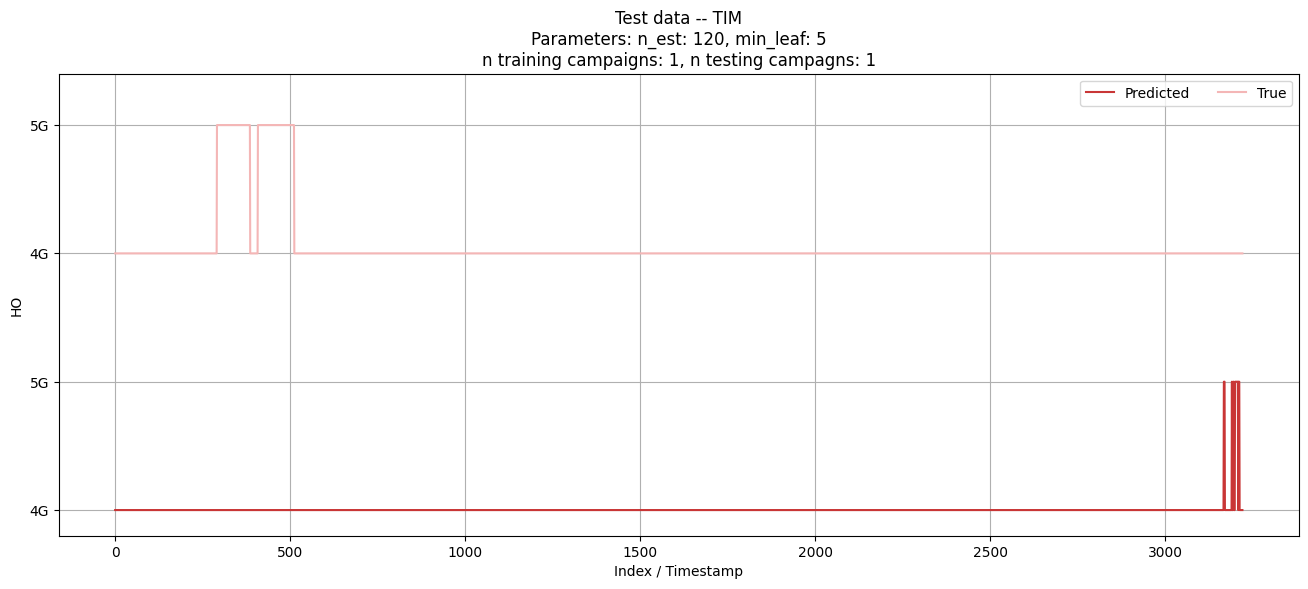

In [247]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

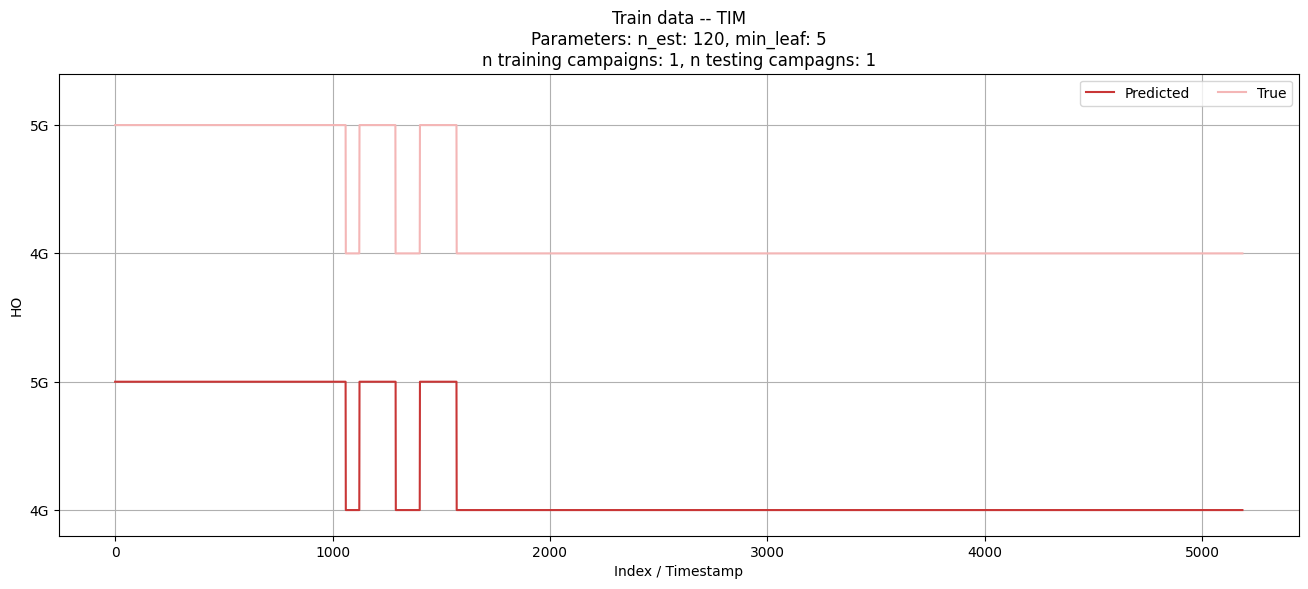

In [248]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- TIM\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()